<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/Projet/GENTIEU_GOUESSE_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : Projet de data analytics


## Détection des anomalies de trajectoire

### Etape 1 : Préparation de l'environnement

Installation du projet : Sur Google Colab :
Allez dans le terminal et exécutez :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

###On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"Projet"
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages/Projet
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

In [6]:
df = pd.read_csv(f"{PROJECT_ROOT}/dataset_trajectoires_anomalies.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       13500 non-null  object 
 1   anomaly_type    13500 non-null  object 
 2   timestamp       13500 non-null  object 
 3   latitude        13500 non-null  float64
 4   longitude       13500 non-null  float64
 5   altitude        13500 non-null  float64
 6   ground_speed    13500 non-null  int64  
 7   vertical_speed  13500 non-null  int64  
 8   heading         13500 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 949.3+ KB


In [8]:
df.describe()

,latitude,longitude,altitude,ground_speed,vertical_speed,heading
count,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000
mean,48.666662,3.323974,6583.362470,348.859778,5.775926,180.456667
std,1.318692,1.705202,2770.046721,87.076987,463.450880,104.743477
min,45.980001,1.900000,500.000000,200.000000,-800.000000,0.000000
25%,48.500000,2.251149,5515.100671,273.000000,-392.000000,89.000000
50%,48.895973,2.567975,7887.703525,348.000000,6.000000,181.000000
75%,49.500000,3.200000,8535.910858,425.000000,406.000000,271.000000
max,50.513801,7.020000,10058.716556,500.000000,800.000000,360.000000


In [9]:
df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159


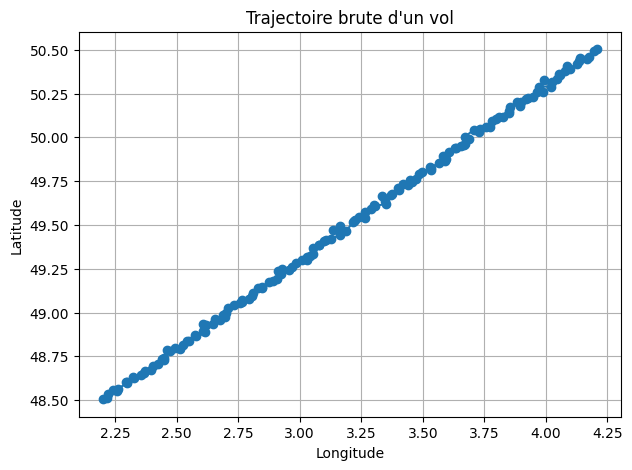

In [12]:
sample = df[df["flight_id"] == df["flight_id"].iloc[0]]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title("Trajectoire brute d'un vol")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [17]:
df["anomaly_type"].unique()


array(['Normal', 'Hijacking_Suspected', 'Sharp_Turn_Diversion',
       'Emergency_Descent', 'Holding_Pattern', 'Glider_Thermal'],
      dtype=object)

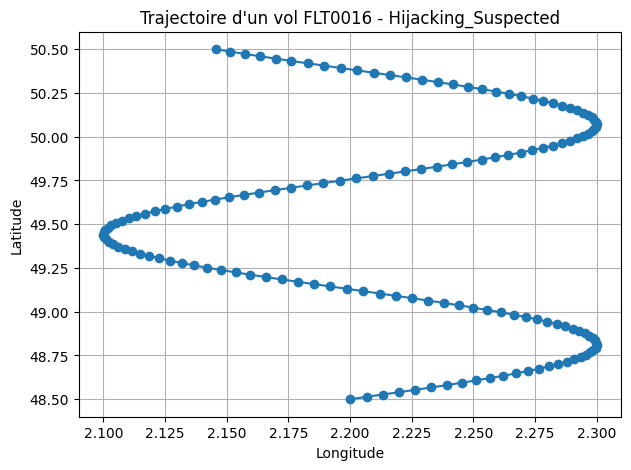

In [18]:
anomaly = "Hijacking_Suspected"

flight_id = df[df["anomaly_type"] == anomaly]["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire d'un vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [ ]:
df = pd.read_csv(output_file)
split_df = df["Message"].str.split(",", expand=True)

# Nommer les colonnes SBS-1
colnames = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

split_df.columns = colnames[:split_df.shape[1]]

df=split_df.copy()

Analyse initiale du dataset :

In [ ]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3,,,A2A3B6,,2025/11/20,08:15:55.243,2025/11/20,08:15:55.243,...,202.0,250.0,50.11797,8.83735,,,0,0,0,0
1,MSG,3,,,043EA0,,2025/11/20,08:15:55.245,2025/11/20,08:15:55.245,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
2,MSG,3,,,45AC4F,,2025/11/20,08:15:55.246,2025/11/20,08:15:55.246,...,330.0,212.0,51.56957,4.85748,,,0,0,0,0
3,MSG,3,,,440C9B,,2025/11/20,08:15:55.248,2025/11/20,08:15:55.248,...,334.0,109.0,49.13595,10.37468,,,0,0,0,0
4,MSG,3,,,4ACA73,,2025/11/20,08:15:55.249,2025/11/20,08:15:55.249,...,142.0,16.0,60.23327,11.10172,,,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549068 entries, 0 to 549067
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   MessageType       549068 non-null  object
 1   TransmissionType  549063 non-null  object
 2   SessionID         549045 non-null  object
 3   AircraftID        549031 non-null  object
 4   HexIdent          549011 non-null  object
 5   FlightID          548904 non-null  object
 6   DateGenerated     548889 non-null  object
 7   TimeGenerated     548739 non-null  object
 8   DateLogged        546124 non-null  object
 9   TimeLogged        530150 non-null  object
 10  Callsign          518004 non-null  object
 11  Altitude          516259 non-null  object
 12  GroundSpeed       510525 non-null  object
 13  Track             497907 non-null  object
 14  Latitude          487700 non-null  object
 15  Longitude         482444 non-null  object
 16  VerticalRate      481943 non-null  obj

In [ ]:
df.describe()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,549068,549063,549045,549031,549011,548904,548889,548739,546124,530150,...,510525,497907,487700,482444,481943,481927,481916,481897,481875,481862
unique,1,2,1,1,1878,1,11,546995,11,519066,...,1504,1058,310228,344745,1,1,2,2,2,2
top,MSG,3,,,043EA0,,2025/11/20,08:,2025/11/20,,...,0.0,0.0,50.00000,20.00000,,,0,0,0,0
freq,549068,549055,549045,549031,5205,548904,548750,35,531844,1629,...,18858,14883,4623,4594,481943,481927,481908,481886,481866,481857


###1.2. Extraction des colonnes utiles

In [ ]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp': df["DateGenerated"] + " " + df["TimeGenerated"]
})

# Convertir le timestamp
df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')


Enfin, avant de construire les différents descripteurs, on va filtrer les datasets pour ne garder que les avions pour lesquels nous avons suffisamment de données (au moins 50 messages) :

In [ ]:
# Nettoyage : supprimer les lignes avec données essentielles manquantes
df_parsed = df_parsed.dropna(subset=["icao", "lat", "lon", "timestamp"])

# ---- Filtrage des icao revenant 50 fois ou plus ----
icao_counts = df_parsed["icao"].value_counts()
icao_valides = icao_counts[icao_counts >= 50].index

df_parsed = df_parsed[df_parsed["icao"].isin(icao_valides)].reset_index(drop=True)
df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,472619.000000,472619.000000,472619.000000,472619.000000,472619.000000,472619
mean,12387.432697,264.844435,171.710295,47.301405,6.572311,2025-11-20 08:29:16.520082176
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000
25%,4817.000000,189.000000,91.000000,45.326230,2.125470,2025-11-20 08:22:50.683500032
50%,10444.000000,279.000000,167.000000,50.013400,7.800070,2025-11-20 08:29:21.230000128
75%,15959.500000,347.000000,258.000000,51.660975,10.789635,2025-11-20 08:35:42.926500096
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000
std,10026.442881,119.926912,102.749224,12.293690,11.263800,NaN


## 1. Construction des descripteurs :

Calcul de la distance totale parcourue avec la méthode Haversine.

Notre dataset contient beaucoup d'erreurs liées aux sauts de valeurs. Nous calculerons donc la distance parcourue à partir des données suivantes :
- La médiane des latitudes et longitudes des 15 premières lignes
- La médiane des latitudes et longitudes des 15 dernières lignes.

On applique ensuite la méthode Haversine sur les données trouvées.

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371_000  # rayon terrestre en mètres
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

distances = []

for icao, group in df_parsed.groupby("icao"):
    g = group.sort_values("timestamp")

    # 1) 15 premières lignes — médianes
    first15 = g.head(15)
    lat_start = first15["lat"].median()
    lon_start = first15["lon"].median()

    # 2) 15 dernières lignes — médianes
    last15 = g.tail(15)
    lat_end = last15["lat"].median()
    lon_end = last15["lon"].median()

    # 3) Distance Haversine entre les deux points médians
    total_dist = haversine(lat_start, lon_start, lat_end, lon_end)

    distances.append({
        "icao": icao,
        "median_haversine_distance": total_dist
    })

# ---- On transforme en DataFrame puis on merge ----
df_dist = pd.DataFrame(distances)

df_parsed = df_parsed.merge(df_dist, on="icao", how="left")

Calcul de la vitesse (groundspeed) moyenne et maximale :

Par souci des erreurs comprises dans le dataset, au lieu de prendre le maximum, on prend le 95e percentile.

In [ ]:
stats_velocity = df_parsed.groupby("icao")["velocity"].agg(
    mean_velocity="mean",
    max_velocity=lambda x: np.nanpercentile(x, 95)
)
df_parsed = df_parsed.merge(stats_velocity, on="icao", how="left")

Calcul du taux de montée médian :

Malgré le fait que l'énoncé nous demande de calculer le taux de montée moyen, les erreurs et pics compris dans le dataset affectent également l'altitude et cela peut amener à une moyenne brute non représentative de ce qui se passe réellement.

Afin de pallier ce problème, on se référera plutôt au taux de montée médian, moins sensible aux irrégularités du dataset.

In [ ]:
df_parsed["alt_shift"] = df_parsed.groupby("icao")["altitude"].shift()
df_parsed["dt"] = df_parsed.groupby("icao")["timestamp"].diff().dt.total_seconds()

# Calcul du taux de montée, en évitant les divisions par zéro
df_parsed["climb_rate"] = (df_parsed["altitude"] - df_parsed["alt_shift"]) / df_parsed["dt"].replace(0, np.nan)

stats_climb = df_parsed.groupby("icao")["climb_rate"].median().rename("median_climb_rate")
df_parsed = df_parsed.merge(stats_climb, on="icao", how="left")

Calcul de la variance du cap (variance de l'attribut "heading")

Du fait que ces données concernent des angles en degré, il convient d'utiliser une variance circulaire, se basant sur les radians, afin d'éviter d'avoir une variance fausse qui considère qu'il y a un grand saut entre 1° et 365° (de 2° réellement).



In [ ]:
# Fonction de variance circulaire (calcul en radians)
def circular_variance_deg(deg_angles):
    # Conversion en radians
    angles = np.deg2rad(deg_angles.dropna())
    if len(angles) == 0:
        return np.nan

    # composantes moyennes
    sin_mean = np.mean(np.sin(angles))
    cos_mean = np.mean(np.cos(angles))

    # resultant vector R
    R = np.sqrt(sin_mean**2 + cos_mean**2)

    # variance circulaire en radians²
    var_rad = 1 - R

    # Conversion en degrés² pour la lisibilité
    var_deg = np.degrees(np.sqrt(var_rad))**2
    return var_deg

# Calcul par avion
stats_heading_deg = (
    df_parsed.groupby("icao")["heading"]
    .apply(circular_variance_deg)
    .rename("circular_heading_variance_deg")
)

# Ajouter la métrique au dataset
df_parsed = df_parsed.merge(stats_heading_deg, on="icao", how="left")


Dispersion géographique : calcul de l'écart-type des latitudes et longitudes

In [ ]:
stats_geo = (
    df_parsed.groupby("icao")[["lat", "lon"]]
    .std()
    .rename(columns={"lat": "std_lat", "lon": "std_lon"})
)
df_parsed = df_parsed.merge(stats_geo, on="icao", how="left")


Calcul de l'indice de linéarité de la trajectoire

In [ ]:
# Calcul de l'indice de linéarité en utilisant la distance totale déjà calculée
linearities = []

for icao, group in df_parsed.groupby("icao"):
    g = group.sort_values("timestamp")

    # Points de départ et d'arrivée robustes : médianes des 15 premières et dernières positions
    start_lat = g.head(15)["lat"].median()
    start_lon = g.head(15)["lon"].median()
    end_lat = g.tail(15)["lat"].median()
    end_lon = g.tail(15)["lon"].median()

    # Distance droite
    straight_distance = haversine(start_lat, start_lon, end_lat, end_lon)

    # Distance totale déjà calculée
    total_distance = g["median_haversine_distance"].iloc[0]  # identique pour toutes les lignes de l'avion

    # Indice de linéarité
    linearity_index = straight_distance / total_distance if total_distance > 0 else np.nan

    linearities.append({"icao": icao, "linearity_index": linearity_index})

# Ajouter au dataset
df_linearities = pd.DataFrame(linearities)
df_parsed = df_parsed.merge(df_linearities, on="icao", how="left")



Calcul du nombre de virages dont l'angle dépasse 25°.

Cette mesure est très complexe, car on doit prendre en compte les différentes erreurs présentes dans le dataset ainsi que les écarts de temps qui sont assez petits entre plusieurs mesures.

L'angle d'un virage sera donc calculé comme tel :
- On prend la médiane des caps des 10 lignes précédentes
- On fait la même chose pour les 10 lignes suivantes.

**On fait ensuite le calcul de l'angle en se basant sur ces valeurs médianes.**

Cela limite les erreurs liées aux sauts de valeurs qu'on trouve de manière récurrente dans le dataset.

In [ ]:
# Fonction pour calculer l'angle entre médianes en radians
def robust_turn_angle_radians(group):
    # Conversion des headings en radians
    headings = np.deg2rad(group["heading"].values)
    n = len(headings)
    turn_angles = np.full(n, np.nan)

    for i in range(n):
        # Médiane des 10 valeurs précédentes
        start = max(0, i-10)
        end = i
        median_prev = np.median(headings[start:end]) if end > start else headings[i]

        # Médiane des 10 valeurs suivantes
        start_next = i+1
        end_next = min(n, i+11)
        median_next = np.median(headings[start_next:end_next]) if end_next > start_next else headings[i]

        # Calcul de l'angle circulaire
        delta = np.angle(np.exp(1j*median_next) / np.exp(1j*median_prev))
        turn_angles[i] = np.abs(delta)  # reste en radians

    return pd.Series(turn_angles, index=group.index)

# Calcul des angles robustes en radians
df_parsed["turn_angle_rad"] = df_parsed.groupby("icao")["heading"].apply(
    lambda x: robust_turn_angle_radians(pd.DataFrame({"heading": x}))
).reset_index(level=0, drop=True)

# Compter les virages > 25° (conversion 25° → radians)
angle_threshold_rad = np.deg2rad(25)
sharp_turns = (
    df_parsed[df_parsed["turn_angle_rad"] > angle_threshold_rad]
    .groupby("icao")["turn_angle_rad"]
    .count()
    .rename("sharp_turns")
)


# Ajouter la métrique au dataset
df_parsed = df_parsed.merge(sharp_turns, on="icao", how="left")
df_parsed["sharp_turns"] = df_parsed["sharp_turns"].fillna(0).astype(int)


On regarde ensuite comment est construit notre dataset pour vérifier que l'on a des résultats cohérents

In [ ]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472619 entries, 0 to 472618
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   icao                           472619 non-null  object        
 1   registration                   472619 non-null  object        
 2   altitude                       472619 non-null  float64       
 3   velocity                       472619 non-null  float64       
 4   heading                        472619 non-null  float64       
 5   lat                            472619 non-null  float64       
 6   lon                            472619 non-null  float64       
 7   timestamp                      472619 non-null  datetime64[ns]
 8   median_haversine_distance      472619 non-null  float64       
 9   mean_velocity                  472619 non-null  float64       
 10  max_velocity                   472619 non-null  float64       
 11  

In [ ]:
df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp,median_haversine_distance,mean_velocity,max_velocity,alt_shift,dt,climb_rate,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,turn_angle_rad,sharp_turns
count,472619.000000,472619.000000,472619.000000,472619.000000,472619.000000,472619,472619.000000,472619.000000,472619.000000,471233.000000,471233.000000,4.712130e+05,472619.000000,472619.000000,472619.000000,472619.000000,466227.0,472619.000000,472619.000000
mean,12387.432697,264.844435,171.710295,47.301405,6.572311,2025-11-20 08:29:16.520082176,118433.732571,264.844435,318.458133,12389.948138,2.509357,6.194403e+01,1.958362,567.019505,0.202913,0.357843,1.0,0.113204,31.189516
min,0.000000,0.000000,0.000000,-44.674920,-118.897450,2025-11-20 08:15:55.243000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.499667e+06,-55.271998,0.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,4817.000000,189.000000,91.000000,45.326230,2.125470,2025-11-20 08:22:50.683500032,40913.760169,228.978763,272.650000,4818.000000,0.441000,-1.936620e+01,-13.563223,36.822325,0.049434,0.111035,1.0,0.000000,0.000000
50%,10444.000000,279.000000,167.000000,50.013400,7.800070,2025-11-20 08:29:21.230000128,84209.471240,281.111953,349.000000,10446.000000,1.265000,0.000000e+00,0.000000,207.974454,0.128770,0.242530,1.0,0.000000,5.000000
75%,15959.500000,347.000000,258.000000,51.660975,10.789635,2025-11-20 08:35:42.926500096,188481.772478,323.434524,399.000000,15954.000000,3.100000,2.063558e+01,16.808523,780.272614,0.282894,0.493615,1.0,0.034907,24.000000
max,215033.000000,729.000000,360.000000,70.339620,175.736980,2025-11-20 08:42:17.264000,381071.591365,516.854369,536.000000,215033.000000,1427.761000,1.134800e+06,73.468937,3274.905575,1.201755,12.859335,1.0,3.141593,737.000000
std,10026.442881,119.926912,102.749224,12.293690,11.263800,NaN,100612.404316,109.204037,123.197299,10023.093724,11.714419,7.336775e+03,18.712085,775.522787,0.209746,0.400270,0.0,0.365431,81.924380


**On remarque ici l'intérêt d'avoir choisi les métriques qu'on a prises.** Par exemple, on observe une occurence d'un taux de montée de l'ordre de 10^6.

Si on avait choisi le taux de montée moyen, il aurait fortement été influencé par ce genre de résultats. Le fait de prendre le taux médian nous permet de pallier ce problème

On affiche quelques données et informations supplémentaires sur notre dataset afin de permettre une meilleure compréhension.

In [ ]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,median_haversine_distance,mean_velocity,...,alt_shift,dt,climb_rate,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,turn_angle_rad,sharp_turns
0,A2A3B6,ICAA2A3B6,4819.0,202.0,250.0,50.11797,8.83735,2025-11-20 08:15:55.243,19741.101504,178.578571,...,NaN,NaN,NaN,-16.853933,0.053341,0.019609,0.082470,1.0,0.0,0
1,043EA0,FLR043EA0,820.0,0.0,0.0,50.00000,20.00000,2025-11-20 08:15:55.245,0.000000,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.794460,NaN,0.0,0
2,45AC4F,OY-KBO,15651.0,330.0,212.0,51.56957,4.85748,2025-11-20 08:15:55.246,76743.920583,268.618932,...,NaN,NaN,NaN,-17.817372,386.338559,0.206990,0.058380,1.0,0.0,0
3,440C9B,OE-LFQ,14471.0,334.0,109.0,49.13595,10.37468,2025-11-20 08:15:55.248,105731.803685,262.785276,...,NaN,NaN,NaN,-10.472858,628.089674,0.095454,0.489788,1.0,0.0,31
4,4ACA73,ICA4ACA73,2677.0,142.0,16.0,60.23327,11.10172,2025-11-20 08:15:55.249,47889.762084,273.517007,...,NaN,NaN,NaN,39.112975,18.478528,0.128406,0.010469,1.0,0.0,4


In [ ]:
# Liste des colonnes finales à garder
columns_to_keep = [
    'icao', 'registration', 'altitude', 'velocity', 'heading', 'lat', 'lon', 'timestamp',
    'median_haversine_distance', 'mean_velocity', 'max_velocity',
    'median_climb_rate', 'circular_heading_variance_deg',
    'std_lat', 'std_lon', 'linearity_index', 'sharp_turns'
]

# Nettoyage du DataFrame
df_prepared = df_parsed[columns_to_keep]
df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472619 entries, 0 to 472618
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   icao                           472619 non-null  object        
 1   registration                   472619 non-null  object        
 2   altitude                       472619 non-null  float64       
 3   velocity                       472619 non-null  float64       
 4   heading                        472619 non-null  float64       
 5   lat                            472619 non-null  float64       
 6   lon                            472619 non-null  float64       
 7   timestamp                      472619 non-null  datetime64[ns]
 8   median_haversine_distance      472619 non-null  float64       
 9   mean_velocity                  472619 non-null  float64       
 10  max_velocity                   472619 non-null  float64       
 11  

## Visualisation des descripteurs.

Pour ce faire, on regroupe dans un dataset les icao et les descripteurs calculés, en triant par le nombre décroissant d'occurences des icao.

In [ ]:
icao_counts = df_parsed["icao"].value_counts().rename("count")

df_icao = df_parsed.groupby("icao").agg({
    "registration": "first",
    "mean_velocity": "first",
    "max_velocity": "first",
    "median_haversine_distance": "first",
    "median_climb_rate": "first",
    "circular_heading_variance_deg": "first",
    "std_lat": "first",
    "std_lon": "first",
    "linearity_index": "first",
    "sharp_turns": "first"
})

df_icao = df_icao.merge(icao_counts, on="icao", how="left")
df_icao = df_icao.sort_values(by="count", ascending=False)

df_icao.head()

,registration,mean_velocity,max_velocity,median_haversine_distance,median_climb_rate,circular_heading_variance_deg,std_lat,std_lon,linearity_index,sharp_turns,count
icao,,,,,,,,,,,
043EA0,FLR043EA0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.794460,NaN,0,4612
4D2537,ICA4D2537,228.978763,261.0,181566.132467,0.000000,9.662500,0.304411,0.497345,1.0,0,3767
4CA295,EI-DEO,267.814783,341.0,87173.530896,-11.207038,1145.639651,0.037456,0.453960,1.0,0,2327
E80421,CC-BDB,273.868569,343.0,100130.144766,-9.276961,956.463574,0.038802,0.498637,1.0,0,2313
404A7E,FLR404A7E,57.204191,66.0,35175.519900,0.000000,93.230160,0.010786,0.151010,1.0,24,2052


In [ ]:
df_icao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1386 entries, 043EA0 to C038CC
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   registration                   1386 non-null   object 
 1   mean_velocity                  1386 non-null   float64
 2   max_velocity                   1386 non-null   float64
 3   median_haversine_distance      1386 non-null   float64
 4   median_climb_rate              1386 non-null   float64
 5   circular_heading_variance_deg  1386 non-null   float64
 6   std_lat                        1386 non-null   float64
 7   std_lon                        1386 non-null   float64
 8   linearity_index                1374 non-null   float64
 9   sharp_turns                    1386 non-null   int64  
 10  count                          1386 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 162.2+ KB


On fait à présent diverses visualisations

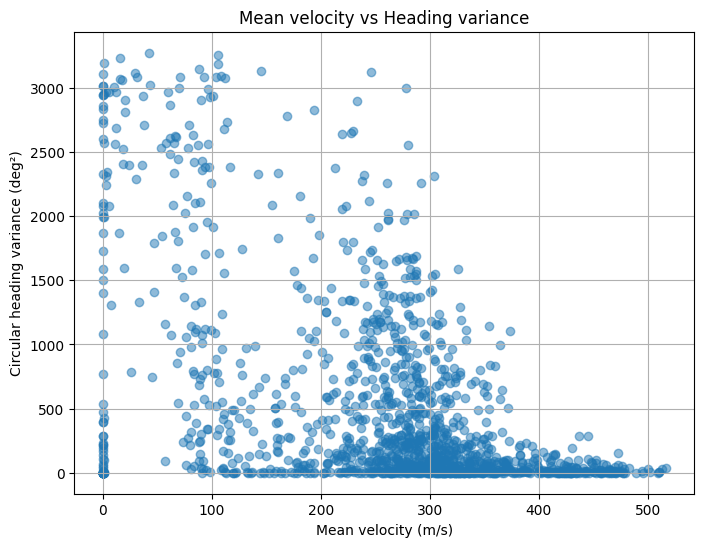

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_icao["mean_velocity"],
            df_icao["circular_heading_variance_deg"],
            alpha=0.5)

plt.xlabel("Mean velocity (m/s)")
plt.ylabel("Circular heading variance (deg²)")
plt.title("Mean velocity vs Heading variance")
plt.grid(True)
plt.show()


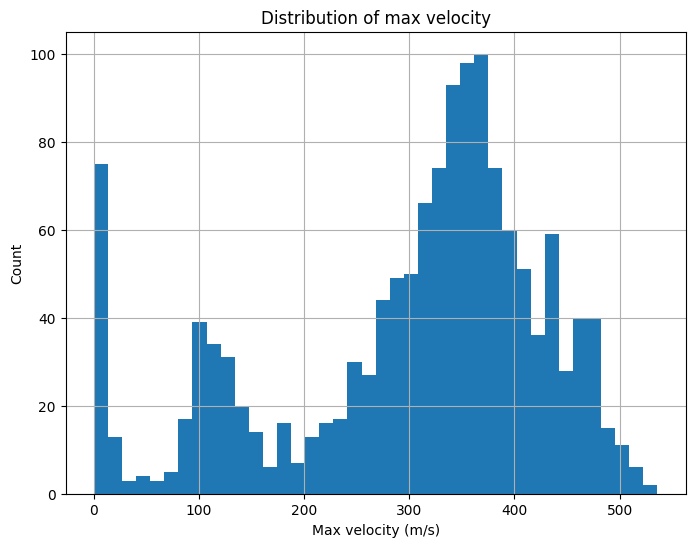

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df_icao["max_velocity"].dropna(), bins=40)
plt.xlabel("Max velocity (m/s)")
plt.ylabel("Count")
plt.title("Distribution of max velocity")
plt.grid(True)
plt.show()


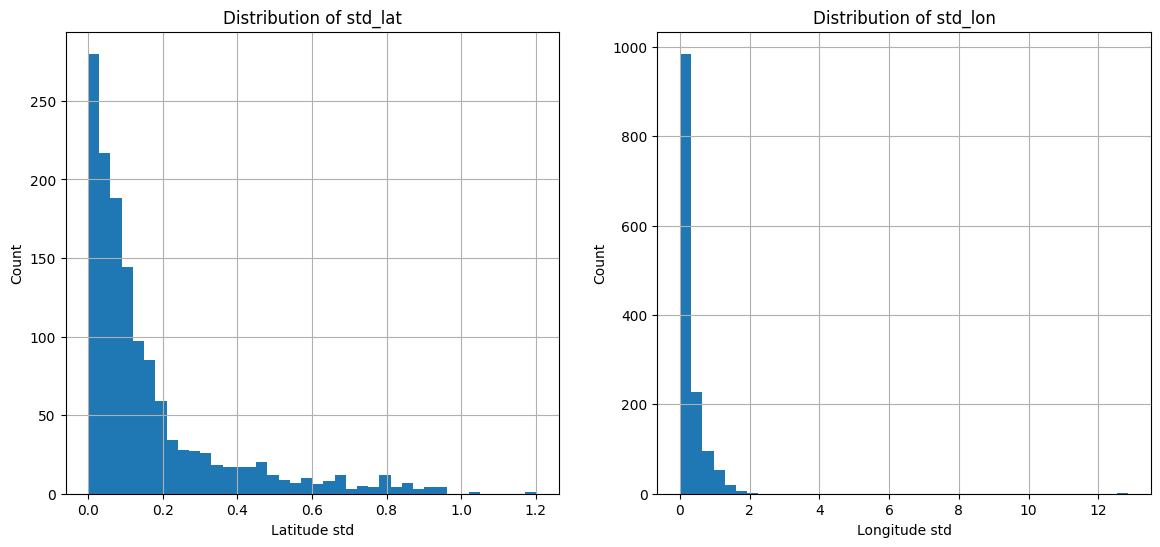

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].hist(df_icao["std_lat"].dropna(), bins=40)
ax[0].set_title("Distribution of std_lat")
ax[0].set_xlabel("Latitude std")
ax[0].set_ylabel("Count")
ax[0].grid(True)

ax[1].hist(df_icao["std_lon"].dropna(), bins=40)
ax[1].set_title("Distribution of std_lon")
ax[1].set_xlabel("Longitude std")
ax[1].set_ylabel("Count")
ax[1].grid(True)

plt.show()


In [ ]:
# 1 : avion le plus linéaire
icao_linear = df_icao["linearity_index"].idxmax()

# 2 : avion le moins linéaire
icao_non_linear = df_icao["linearity_index"].idxmin()

# 3 : avion avec le plus de virages
icao_turns = df_icao["sharp_turns"].idxmax()

# 4 : avion le plus rapide (mean_velocity)
icao_fast = df_icao["mean_velocity"].idxmax()

# 5 : avion le plus "dispersé" (std_lat + std_lon)
icao_scattered = (df_icao["std_lat"] + df_icao["std_lon"]).idxmax()

selected_icaos = {
    "Most linear": icao_linear,
    "Least linear": icao_non_linear,
    "Most turns": icao_turns,
    "Fastest": icao_fast,
    "Most scattered": icao_scattered
}

selected_icaos


{'Most linear': '4D2537',
 'Least linear': '4D2537',
 'Most turns': '502C8A',
 'Fastest': 'A97CB5',
 'Most scattered': 'DDBA88'}

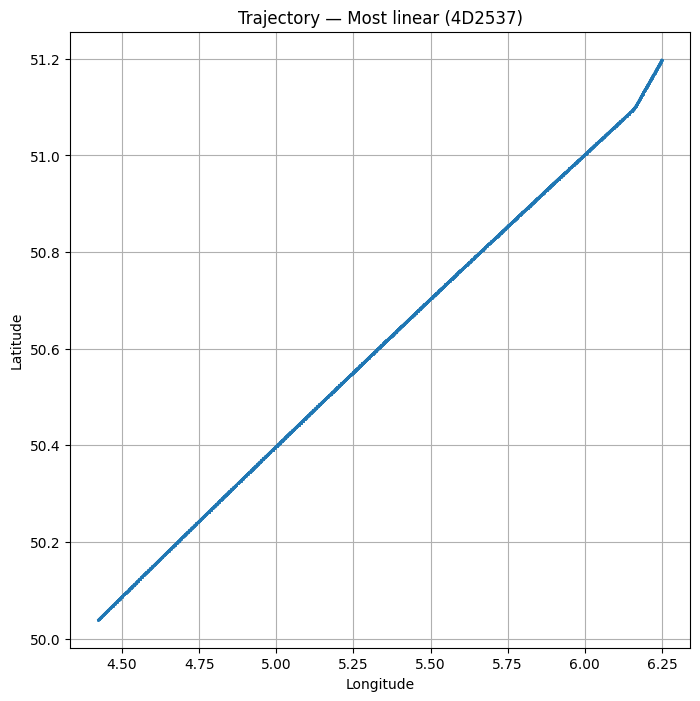

In [ ]:
label = "Most linear"   # ← changer ici
icao = selected_icaos[label]

df_track = df_prepared[df_prepared["icao"] == icao].sort_values("timestamp")

plt.figure(figsize=(8,8))
plt.plot(df_track["lon"], df_track["lat"], marker=".", markersize=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Trajectory — {label} ({icao})")
plt.grid(True)
plt.show()


## On sélectionne maintenant un avion en particulier

On trie ensuite par timestamp pour obtenir les messages triés en fonction du temps (du plus vieux au plus récent)

In [ ]:
"""
# On teste pour plusieurs avions au cas où on observe des erreurs.
icao_sample = df_parsed['icao'].value_counts().index[0]
icao_sample2 = df_parsed['icao'].value_counts().index[1]
icao_sample3 = df_parsed['icao'].value_counts().index[2]
icao_sample4 = df_parsed['icao'].value_counts().index[3]
icao_sample5 = df_parsed['icao'].value_counts().index[4]
icao_sample6 = df_parsed['icao'].value_counts().index[5]
icao_sample7 = df_parsed['icao'].value_counts().index[6]
icao_sample8 = df_parsed['icao'].value_counts().index[7]
icao_sample9 = df_parsed['icao'].value_counts().index[8]
icao_sample10 = df_parsed['icao'].value_counts().index[9]
print(icao_sample)
print(icao_sample2)
print(icao_sample3)
print(icao_sample4)
print(icao_sample5)
flight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')
flight.info()
"""

"\n# On teste pour plusieurs avions au cas où on observe des erreurs.\nicao_sample = df_parsed['icao'].value_counts().index[0]\nicao_sample2 = df_parsed['icao'].value_counts().index[1]\nicao_sample3 = df_parsed['icao'].value_counts().index[2]\nicao_sample4 = df_parsed['icao'].value_counts().index[3]\nicao_sample5 = df_parsed['icao'].value_counts().index[4]\nicao_sample6 = df_parsed['icao'].value_counts().index[5]\nicao_sample7 = df_parsed['icao'].value_counts().index[6]\nicao_sample8 = df_parsed['icao'].value_counts().index[7]\nicao_sample9 = df_parsed['icao'].value_counts().index[8]\nicao_sample10 = df_parsed['icao'].value_counts().index[9]\nprint(icao_sample)\nprint(icao_sample2)\nprint(icao_sample3)\nprint(icao_sample4)\nprint(icao_sample5)\nflight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')\nflight.info()\n"